# Finding Arsenal's Next Goal Scorer
## Introduction
As Arsenal get closer and closer to an English Premier League title, many say that their biggest need in terms of personnel is an **"out-and-out" striker** -- an attacking player who gets on the end of passes and puts the finishing touch on Arsenal's clever build-up play. I'll use this dataset of player stats across Europe's 5 top leagues to identify **transfer prospects** that Arsenal could attempt to sign in the next transfer window, which opens in Summer 2025. 

Note: This dataset is available on Kaggle, here: https://www.kaggle.com/datasets/hubertsidorowicz/football-players-stats-2024-2025. It includes player stats from the 2024-2025 season which is still in progress. This version of the data was downloaded on February 20, 2025. 

In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the working directory from which we'll access the dataset
import os
os.chdir("/Users/macbook/Documents/data_projects/arsenal")

# Read in the data into a Pandas dataframe
df = pd.read_csv("players_data-2024_2025.csv")

# See the number of rows and columns
df.shape

(2698, 267)

In [6]:
# Take a look at the first few rows
df.head()

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Att (GK),Thr,Launch%,AvgLen,Opp,Stp,Stp%,#OPA,#OPA/90,AvgDist
0,1,Max Aarons,eng ENG,DF,Bournemouth,eng Premier League,25.0,2000.0,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Max Aarons,eng ENG,MF,Valencia,es La Liga,25.0,2000.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Rodrigo Abajas,es ESP,DF,Valencia,es La Liga,21.0,2003.0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,James Abankwah,ie IRL,"DF,MF",Udinese,it Serie A,21.0,2004.0,6,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Keyliane Abdallah,fr FRA,FW,Marseille,fr Ligue 1,18.0,2006.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset has 2,698 rows, each representing one player at one club. It looks like if a player has changed clubs in the middle of this season, they will have one row for each team they've played for. This means their stats will be split up on more than one row, potentially diluting their goal-scoring record. However, since we're interested in players that Arsenal can sign this coming summer, we'll assume that players that have only recently changed clubs are unlikely to do so again. So we'll leave this alone. 

Additionally, there are 267 columns of data for each entry. We'll end up just using a subset of those columns for this analysis. 

## Data Cleaning
First, let's narrow down the dataset to include just the columns that are relevant for this analysis:

- Player – Player's name
- Pos – Position (FW, MF, DF, GK)
- Squad – Club name
- Comp – League
- Age – Age of the player
- MP – Matches played
- Starts – Games started
- Min – Minutes played
- 90s – Number of full 90-minute matches played
- Gls – Goals scored
- Ast – Assists provided
- G+A – Goals + Assists
- xG – Expected goals
- xAG – Expected assists
- npxG – Non-penalty expected goals
- G-PK – Goals excluding penalties



In [9]:
df_clean = df[["Player", "Pos", "Squad", "Comp", "Age", "MP", "Starts", "Min", "90s", "Gls", "Ast", "G+A", "xG", "xAG", "npxG", "G-PK"]]
df_clean.shape

(2698, 16)

Next, let's examine the remaining columns to check for missing values and make sure the data types are conducive to analysis. 

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2698 entries, 0 to 2697
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  2698 non-null   object 
 1   Pos     2698 non-null   object 
 2   Squad   2698 non-null   object 
 3   Comp    2698 non-null   object 
 4   Age     2694 non-null   float64
 5   MP      2698 non-null   int64  
 6   Starts  2698 non-null   int64  
 7   Min     2698 non-null   int64  
 8   90s     2698 non-null   float64
 9   Gls     2698 non-null   int64  
 10  Ast     2698 non-null   int64  
 11  G+A     2698 non-null   int64  
 12  xG      2698 non-null   float64
 13  xAG     2698 non-null   float64
 14  npxG    2698 non-null   float64
 15  G-PK    2698 non-null   int64  
dtypes: float64(5), int64(7), object(4)
memory usage: 337.4+ KB


All the data types look good. However, there are 4 players where "Age" is blank. Let's take a look at them.

In [13]:
df_clean[df_clean["Age"].isnull() == True]

,Player,Pos,Squad,Comp,Age,MP,Starts,Min,90s,Gls,Ast,G+A,xG,xAG,npxG,G-PK
261,Hannes Behrens,DF,Hoffenheim,de Bundesliga,NaN,1,0,29,0.3,0,0,0,0.0,0.0,0.0,0
627,Pape Daouda Diongue,"MF,FW",Strasbourg,fr Ligue 1,NaN,7,1,73,0.8,1,0,1,1.0,0.2,1.0,1
1434,Fer López,FW,Celta Vigo,es La Liga,NaN,5,2,144,1.6,0,0,0,0.2,0.6,0.2,0
1671,Max Moerstedt,FW,Hoffenheim,de Bundesliga,NaN,11,4,394,4.4,0,0,0,0.7,0.3,0.7,0


We might be able to fix this using the players' birth year, which is in the original dataset. Let's look back in the original dataset and see if these 4 players' birth years are included.

In [15]:
df[["Player", "Age", "Born"]][df["Age"].isnull() == True]

,Player,Age,Born
261,Hannes Behrens,NaN,NaN
627,Pape Daouda Diongue,NaN,NaN
1434,Fer López,NaN,NaN
1671,Max Moerstedt,NaN,NaN


These 4 players don't have birth years listed either. Luckily, none of them have scored many goals, so leaving them out won't impact our analysis too much. Let's go ahead and drop them from our subset.

In [17]:
# Filter the subset to leave out rows where "Age" is null.
df_clean = df_clean[df_clean["Age"].isnull() == False]

# Make sure the subset now has 2,694 rows
df_clean.shape

(2694, 16)

Now that we have our cleaned subset, we'll proceed with the analysis.

## Understanding the Need
To understand Arsenal's need for a singular scoring threat, we can compare **top individual scorers for different teams**. For this example, let's look at all 20 teams currently in the **English Premier League** and see how Arsenal's top goal scorer compares to the top goal scorers on other teams.

In [20]:
# Initialize an empty DataFrame to store the top scorer for each team
eng_team_top_scorers = pd.DataFrame(columns=["Squad", "Top Scorer", "Gls"])

# Make a list of all English Premier League teams to loop through
eng_teams = df_clean[df_clean["Comp"] == "eng Premier League"]["Squad"].unique().tolist()

# Loop through each team and add their top scorer to the DataFrame
for team in eng_teams:
    players = df_clean[df_clean["Squad"] == team]
    top_scorer = players.sort_values("Gls", ascending=False).head(1)
    
    squad_name = top_scorer["Squad"].values[0]
    player_name = top_scorer["Player"].values[0]
    goals = top_scorer["Gls"].values[0]
    
    eng_team_top_scorers.loc[len(eng_team_top_scorers)] = [squad_name, player_name, goals]

# Sort the DataFrame to show each team's top scorer in descending order
eng_team_top_scorers = eng_team_top_scorers.sort_values("Gls", ascending=False)
print(eng_team_top_scorers.to_string(index=False))

          Squad           Top Scorer  Gls
      Liverpool        Mohamed Salah   23
Manchester City       Erling Haaland   19
Nott'ham Forest           Chris Wood   18
  Newcastle Utd       Alexander Isak   17
        Chelsea          Cole Palmer   14
      Brentford         Bryan Mbeumo   14
         Wolves        Matheus Cunha   12
    Aston Villa        Ollie Watkins   11
    Bournemouth      Justin Kluivert   11
 Crystal Palace Jean-Philippe Mateta   11
   Ipswich Town           Liam Delap   10
         Fulham         Raúl Jiménez    9
      Tottenham       James Maddison    9
        Arsenal          Kai Havertz    9
 Leicester City          Jamie Vardy    7
        Everton        Iliman Ndiaye    6
       West Ham         Jarrod Bowen    6
 Manchester Utd          Amad Diallo    6
       Brighton        Danny Welbeck    6
    Southampton            Joe Aribo    3


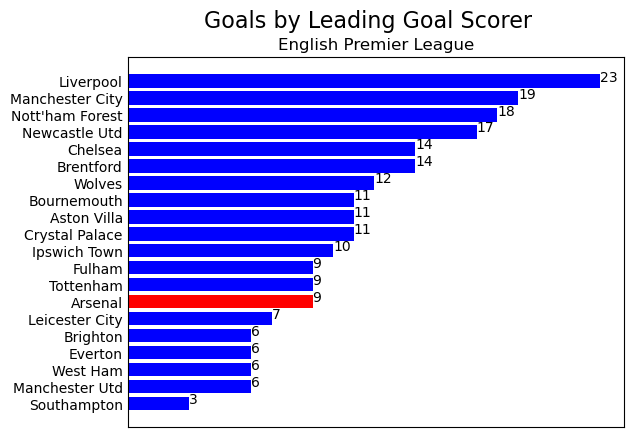

In [21]:
# Reorder the DataFrame to sort properly in a horizontal bar chart
eng_team_top_scorers = eng_team_top_scorers.sort_values("Gls", ascending=True)

# Set the colors of each bar to highlight Arsenal's top scorer in relation to other teams
colors = ['blue'] * len(eng_team_top_scorers)
colors[6] = 'red'  

# Create the chart
plt.barh(eng_team_top_scorers["Squad"], eng_team_top_scorers["Gls"], color=colors)
plt.suptitle("Goals by Leading Goal Scorer", size=16)
plt.title("English Premier League")
plt.tick_params(axis='both', which='both', length=0)
plt.xticks([])
colors[1] = 'red' 

# Add value labels to each bar
for index, value in enumerate(eng_team_top_scorers["Gls"]):
    plt.text(value, index, str(value))

As we can see from the table and the chart above, Arsenal ranks relatively low in the English Premier League in terms of a singular goal-scorer. Arsenal's top scorer, Kai Havertz, has 9 goals so far this season in the Premier League. However, most teams in the league have an individual goal scorer who has scored more than Havertz. Furthermore, the other 3 teams aside from Arsenal currently in the top 4 (Liverpool, Manchester City, and Nottingham Forest) each have a distinct goal-scoring threat (Mohamed Salah with 23 goals, Erling Haaland with 19 goals, and Chris Wood with 18 goals, respectively). 

## Attacking Prospects
Given Arsenal's need for a definitive goal-scorer, let's now look at **attacking players that Arsenal could attempt to sign** in the coming summer transfer window. We'll start by looking at the top individual goal scorers across all 5 European leagues in the dataset.

In [24]:
df_clean[["Player", "Age", "Pos", "Squad", "Comp", "Gls"]].sort_values("Gls", ascending=False).head(20)

,Player,Age,Pos,Squad,Comp,Gls
2170,Mohamed Salah,32.0,FW,Liverpool,eng Premier League,23
1240,Harry Kane,31.0,FW,Bayern Munich,de Bundesliga,21
2075,Mateo Retegui,25.0,FW,Atalanta,it Serie A,20
1042,Erling Haaland,24.0,FW,Manchester City,eng Premier League,19
1401,Robert Lewandowski,36.0,FW,Barcelona,es La Liga,19
2632,Chris Wood,33.0,FW,Nott'ham Forest,eng Premier League,18
1594,Kylian Mbappé,26.0,FW,Real Madrid,es La Liga,17
1146,Alexander Isak,25.0,FW,Newcastle Utd,eng Premier League,17
659,Ousmane Dembélé,27.0,FW,Paris S-G,fr Ligue 1,16
1252,Moise Kean,24.0,FW,Fiorentina,it Serie A,15


Clearly, there are many talented goal-scorers across these 5 leagues. However, many of these players are well-established at their clubs and may be difficult to sign. We can also consider the fact that teams inside England may be reluctant to send one of their top players to Arsenal, their opponent. And finally, Arsenal may be more interested in signing a younger player who will continue to develop and could stay with the club for many years. For all these reasons, we'll narrow our search to **younger players** (for example, 25 and under) and players **outside England**.

Text(0, 0.5, 'Goals')

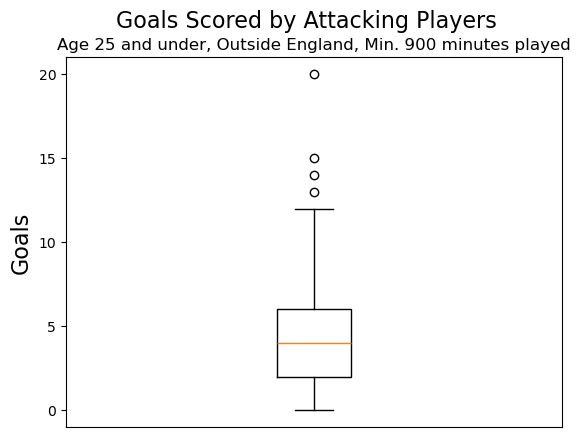

In [26]:
# Filter for age 25 and under
prospect_pool = df_clean[df_clean["Age"] < 26]

# Filter for leagues outside England
leagues_to_keep = ["de Bundesliga", "it Serie A", "es La Liga", "fr Ligue 1"]
prospect_pool = prospect_pool[prospect_pool["Comp"].isin(leagues_to_keep)]

# Use a box plot to show the distribution of goals scored by remaining attacking players
prospect_pool_filtered = prospect_pool[prospect_pool["Pos"].str.contains(r'FW', regex=True)]
prospect_pool_filtered = prospect_pool_filtered[prospect_pool_filtered["Min"] >= 900]
plt.boxplot(prospect_pool_filtered["Gls"])
plt.suptitle("Goals Scored by Attacking Players", size=16)
plt.title("Age 25 and under, Outside England, Min. 900 minutes played")
plt.xticks([])
plt.yticks([0, 5, 10, 15, 20])
plt.ylabel("Goals", size=16)

In the code cell above, we condensed our dataset to include players age 25 and under who play for teams outside the English Premier League. We then used a box plot to show the **distribution of goals scored** by attacking players in the remaining dataset. Note, for the box plot we looked at attacking players (those with "FW" in their position name) and those who have played a minimum of 900 minutes (about 10 games). This helps to get a sense of what is a typical goal-scoring record for an attacking player in our condensed dataset, so we can zero in on the **upper end** of that distribution for our search. We can see that the average number of goals for these players is just under 5. Higher-scoring players tend to have reached up to around 12 goals, while a few outliers have scored more than that. Let's look at those higher-scoring players now.

In [28]:
# Keep only those who have scored 12 or more goals
prospects = prospect_pool[prospect_pool["Gls"] >= 12]
prospects.sort_values("Gls", ascending=False)

,Player,Pos,Squad,Comp,Age,MP,Starts,Min,90s,Gls,Ast,G+A,xG,xAG,npxG,G-PK
2075,Mateo Retegui,FW,Atalanta,it Serie A,25.0,23,19,1371,15.2,20,3,23,11.6,2.1,9.3,18
1252,Moise Kean,FW,Fiorentina,it Serie A,24.0,23,22,1927,21.4,15,2,17,12.7,1.7,11.1,14
993,Mason Greenwood,"FW,MF",Marseille,fr Ligue 1,23.0,22,22,1865,20.7,14,3,17,10.8,4.0,6.0,9
394,Jonathan Burkardt,FW,Mainz 05,de Bundesliga,24.0,18,17,1208,13.4,13,2,15,9.8,2.1,9.0,12
634,Jonathan David,FW,Lille,fr Ligue 1,25.0,20,17,1629,18.1,12,3,15,12.2,2.9,6.7,6
777,Hugo Ekitike,FW,Eint Frankfurt,de Bundesliga,22.0,21,20,1596,17.7,12,3,15,15.1,3.6,13.5,11
2190,Oihan Sancet,MF,Athletic Club,es La Liga,24.0,20,16,1280,14.2,12,1,13,7.9,1.4,6.3,10


Great, now we're getting somewhere! We've identified **7 good goal-scorers** age 25 and under who play for teams outside England. This list would be a great place for Arsenal to start looking for their next goal-scoring threat to add to their squad. But before we finish up, let's narrow it down a bit further and use some of the **other stats** columns to find some stand-out prospects. A couple ideas come to mind:

- First, how many of their goals come from **penalty kicks**? Since penalty kicks are much easier to score, and since we're looking for a player who can finish off Arsenal's attacks from the run of play, let's make sure we're looking at players who don't have too many of their goals coming from penalty kicks.
- Second, since the number of minutes played varies across players, let's create a measure of **goal-scoring efficiency**, that considers how often a player scores while they're on the pitch.

In [30]:
prospects = prospects.copy()

# Create a new column showing percentage of goals that don't come from penalty kicks. 
# Note: "G-PK" is the number of goals that are NOT penalty kicks.
prospects["non-PK_percent"] = round(prospects["G-PK"] / prospects["Gls"] * 100, 2)

# Create a new column showing how many minutes it takes for each goal
prospects["min_per_goal"] = round(prospects["Min"] / prospects["Gls"], 2)

# Show the new columns
prospects[["Player", "Age", "Pos", "Squad", "Comp", "Gls", "non-PK_percent", "min_per_goal"]].sort_values(["Gls", "non-PK_percent", "min_per_goal"], ascending=False)

,Player,Age,Pos,Squad,Comp,Gls,non-PK_percent,min_per_goal
2075,Mateo Retegui,25.0,FW,Atalanta,it Serie A,20,90.00,68.55
1252,Moise Kean,24.0,FW,Fiorentina,it Serie A,15,93.33,128.47
993,Mason Greenwood,23.0,"FW,MF",Marseille,fr Ligue 1,14,64.29,133.21
394,Jonathan Burkardt,24.0,FW,Mainz 05,de Bundesliga,13,92.31,92.92
777,Hugo Ekitike,22.0,FW,Eint Frankfurt,de Bundesliga,12,91.67,133.00
2190,Oihan Sancet,24.0,MF,Athletic Club,es La Liga,12,83.33,106.67
634,Jonathan David,25.0,FW,Lille,fr Ligue 1,12,50.00,135.75


The 2 new columns we made help to narrow down the best goal scorers from our list. For example, although Mason Greenwood and Jonathan David have scored a lot of goals, they've had penalty kicks account for a larger proportion of those goals. So we might not recommend them as top prospects for Arsenal's purposes. Additionally, we can see that Mateo Retegui and Jonathan Burkardt are very efficient scorers. Burkardt averages almost 1 goal for every 90-minute game while Retegui scores even more frequently than that. To formalize this a bit, let's assign ranks for each of our 3 goal-related columns and give each player a **composite rank**.

In [32]:
# Create columns to rank each player on the 3 goal-related stats
prospects["Gls_rank"] = prospects["Gls"].rank(ascending=False, method="dense")
prospects["non-PK_rank"] = prospects["non-PK_percent"].rank(ascending=False, method="dense")
prospects["min_per_goal_rank"] = prospects["min_per_goal"].rank(ascending=True, method="dense")

# Create a composite rank that sums all the ranks together
prospects["composite_rank"] = prospects["Gls_rank"] + prospects["non-PK_rank"] + prospects["min_per_goal_rank"]

# Show the results, sorted by the composite rank
prospects[["Player", "Age", "Pos", "Squad", "Comp", "Gls_rank", "non-PK_rank", "min_per_goal_rank", "composite_rank"]].sort_values("composite_rank", ascending=True)

,Player,Age,Pos,Squad,Comp,Gls_rank,non-PK_rank,min_per_goal_rank,composite_rank
2075,Mateo Retegui,25.0,FW,Atalanta,it Serie A,1.0,4.0,1.0,6.0
1252,Moise Kean,24.0,FW,Fiorentina,it Serie A,2.0,1.0,4.0,7.0
394,Jonathan Burkardt,24.0,FW,Mainz 05,de Bundesliga,4.0,2.0,2.0,8.0
777,Hugo Ekitike,22.0,FW,Eint Frankfurt,de Bundesliga,5.0,3.0,5.0,13.0
2190,Oihan Sancet,24.0,MF,Athletic Club,es La Liga,5.0,5.0,3.0,13.0
993,Mason Greenwood,23.0,"FW,MF",Marseille,fr Ligue 1,3.0,6.0,6.0,15.0
634,Jonathan David,25.0,FW,Lille,fr Ligue 1,5.0,7.0,7.0,19.0


As we can see from this ranking exercise, the top prospect is **Mateo Retegui** (Atalanta). Retegui ranks 1st in goals scored and goal-scoring efficiency and ranks 4th in non-PK percentage, leading to a composite rank of 6. He is followed in composite rank by **Moise Kean** (Fiorentina) and **Jonathan Burkardt** (Mainz).

## Conclusion
In this project, we began with a dataset of soccer player stats from the 2024-2025 season for Europe's top 5 leagues. We showed Arsenal's lack of a singular goal-scoring threat when compared to other teams in the English Premier League and looked for possible players that Arsenal could sign to fill the gap. We identified 7 good, young goal-scorers in leagues outside England and analyzed their goal-scoring stats to pick out the top prospects. In the end, we were able to recommend **Mateo Retegui** (Atalanta), **Moise Kean** (Fiorentina), and **Jonathan Burkardt** (Mainz) for Arsenal to pursue in the Summer 2025 transfer window.